<a href="https://colab.research.google.com/github/cyclingdata/tensorflow_practice_coursera/blob/master/S%2BP_Week_4_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-04-03 23:40:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-04-03 23:40:54 (155 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



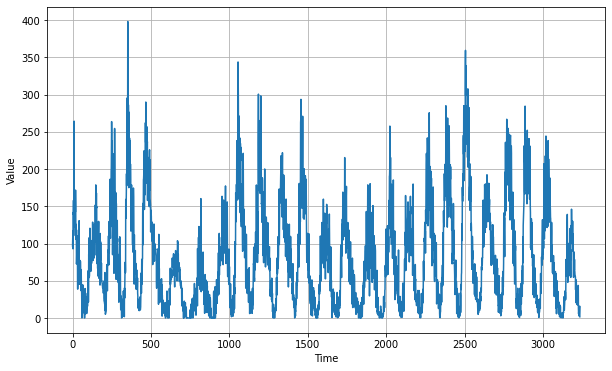

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

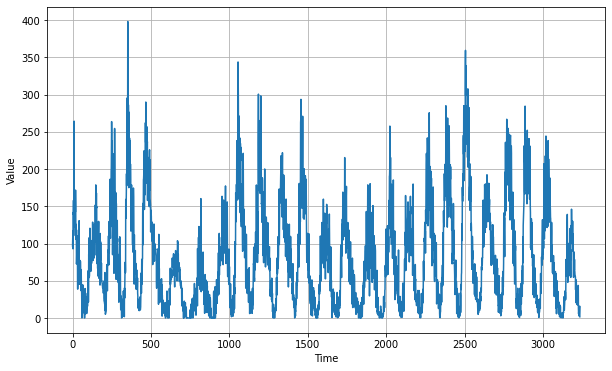

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 24ms/step - loss: 92.8993 - mae: 93.4423 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 89.9756 - mae: 90.2702 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 85.5124 - mae: 85.9409 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 24ms/step - loss: 80.8598 - mae: 81.3141 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 25ms/step - loss: 76.3023 - mae: 76.7789 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 72.0100 - mae: 72.4411 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 67.7276 - mae: 68.1493 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 63.2456 - mae: 63.6905 - l

(1e-08, 0.0001, 0.0, 60.0)

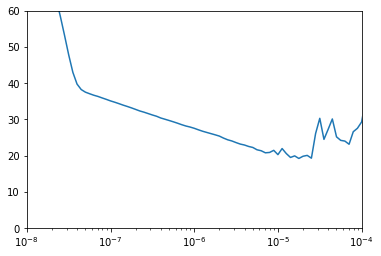

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 15ms/step - loss: 38.7166 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 25.7313 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 22.0652 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 20.4652 - mae: 20.9621
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 19.7129 - mae: 20.2075
Epoch 6/500
30/30 [==============================] - 0s 15ms/step - loss: 19.2382 - mae: 19.7499
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 18.6147 - mae: 19.1244
Epoch 8/500
30/30 [==============================] - 0s 14ms/step - loss: 18.3500 - mae: 18.8162
Epoch 9/500
30/30 [==============================] - 0s 14ms/step - loss: 18.1322 - mae: 18.6079
Epoch 10/500
30/30 [==============================] - 0s 14ms/step - loss: 19.7946 - mae: 20.2978
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

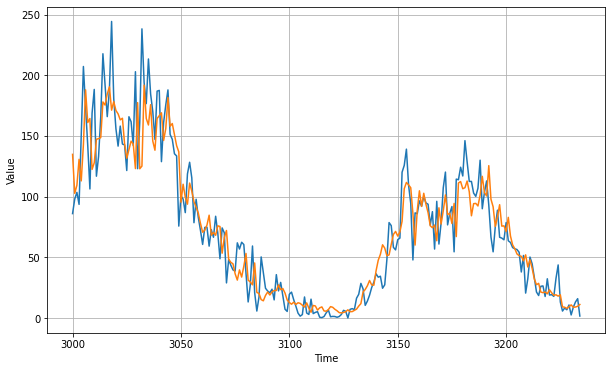

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.640048

<Figure size 432x288 with 0 Axes>

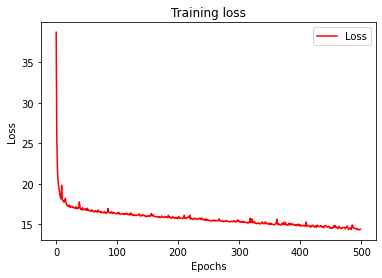

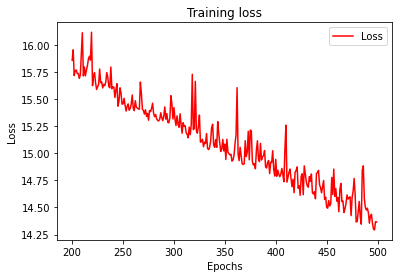

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[134.79437   102.6716    109.35098   130.71669   112.94041   142.76257
 187.96848   160.99788   164.33876   122.41499   127.833466  147.21738
 147.75867   148.58862   178.0066    175.41594   184.58221   190.42784
 171.2429    178.26361   170.96909   168.1648    163.23439   164.56996
 143.44943   131.62967   138.52596   145.69907   143.29057   123.08856
 177.42393   122.939255  125.12391   191.809     164.36089   159.00822
 175.7485    145.79312   138.22792   164.35915   166.68677   169.03702
 146.28047   156.11084   181.57411   157.95049   160.19737   150.86264
 141.95555   136.89444    95.40827   110.181046   99.45204    93.74346
 111.15683   104.61684    95.77986    91.3627     86.44322    77.92641
  70.62393    72.442215   76.55088    84.6845     68.23602    70.51123
  68.14029    75.93655    75.36844    53.37912    66.26696    72.074165
  48.46797    45.869194   44.595306   36.35943    31.214146   39.60042
  33.70828    42.598732   53.140736   31.169384   29.640038   27.328226
  45